In [59]:
%matplotlib inline

## Imports

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

## Load the data file
**Note: A small amount of pre-processing was done on the original file, as follows.**
* (1) Flatten GWAS columns (see `flattener.py`), since multiple entries exist separated by `|`.
* (2) Filter for `gwas_source = 'GWAS Catalog`, since only these records of interest.
Result:
```
postgap.20170825.txt.gz -> postgap.20170825.gwas.flat.txt.gz
```

The command line calls for (2) are:
```
gzcat postgap.20170825.flat.txt.gz | head -n1 | gzip > postgap.20170825.gwas.flat.txt.gz
gzcat postgap.20170825.flat.txt.gz | grep 'GWAS Catalog' | gzip >> postgap.20170825.gwas.flat.txt.gz
```

In [3]:
pg = pd.read_csv('postgap.20170825.gwas.flat.txt.gz', sep='\t', na_values=['None'])
print(pg.shape)
pg.head()

/Users/gpeat/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21,24,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4928870, 38)


,gwas_pvalue,PCHiC,VEP_reg,gwas_source,rank,cluster_id,eas_maf,gwas_pmid,gwas_size,ls_snp_is_gwas_snp,...,Fantom5,disease_efo_id,chrom,ld_snp_rsID,Nearest,r2,amr_maf,gwas_snp,sas_maf,vep_sum
0,5.000000e-54,1.0,0.0,GWAS Catalog,1,980625596102493982,0.6548,PMID23996088,9318,0,...,0.0,EFO_0000094,10,rs10761598,0.0,0.943195,0.5101,rs7090445,0.4796,0.0
1,5.000000e-54,1.0,0.0,GWAS Catalog,3,980625596102493982,0.6736,PMID23996088,9318,0,...,0.0,EFO_0000094,10,rs10740053,0.0,0.950436,0.5317,rs7090445,0.4888,0.0
2,5.000000e-54,1.0,0.0,GWAS Catalog,3,980625596102493982,0.6736,PMID23996088,9318,0,...,0.0,EFO_0000094,10,rs10740053,0.0,0.950436,0.5317,rs7090445,0.4888,0.0
3,5.000000e-54,1.0,0.0,GWAS Catalog,2,980625596102493982,0.6538,PMID23996088,9318,0,...,0.0,EFO_0000094,10,rs4506592,0.0,0.943193,0.5101,rs7090445,0.4785,0.0
4,5.000000e-54,1.0,0.0,GWAS Catalog,2,980625596102493982,0.6538,PMID23996088,9318,0,...,0.0,EFO_0000094,10,rs4506592,0.0,0.943193,0.5101,rs7090445,0.4785,0.0


## Datamodel
POSTGAP data has many columns of data, but the unique key is `(ld_snp_rsID, gwas_snp, gene_id, disease_efo_id, gwas_pmid)`.

**Question**: Is this combination indeed unique?

In [4]:
primary_key = ['ld_snp_rsID', 'gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
primary_key_groups = pg.groupby(primary_key)
primary_key_group_sizes = primary_key_groups.size()
primary_key_groups_non_unique = primary_key_group_sizes[primary_key_group_sizes > 1]
# if the primary_key is unique, then primary_key_groups_non_unique should be empty
print(primary_key_groups_non_unique.shape)
primary_key_groups_non_unique.sort_values(ascending=False).head()
# note: to see the first hit in the original file, on the command line, do:
# gzcat postgap.20170825.txt.gz | grep 'rs3177243' | grep 'rs2186369' | grep 'ENSG00000099958' | grep 'EFO_0005193' | grep 'PMID23382691'

(491201,)


ld_snp_rsID  gwas_snp   gene_id          disease_efo_id  gwas_pmid   
rs3177243    rs2186369  ENSG00000099958  EFO_0005193     PMID23382691    23
rs9624334    rs2186369  ENSG00000099958  EFO_0005193     PMID23382691    23
rs3177243    rs2186369  ENSG00000099956  EFO_0005193     PMID23382691    23
                        ENSG00000250479  EFO_0005193     PMID23382691    23
rs5030614    rs2186369  ENSG00000267954  EFO_0005193     PMID23382691    23
dtype: int64

**Question**: How many unique `ld_snp_rsID` values are there? How about the other elements of the unique key?

In [5]:
print('Genes: {}'.format(pg['gene_id'].nunique()))
print('LD SNPs: {}'.format(pg['ld_snp_rsID'].nunique()))
print('GWAS SNPs: {}'.format(pg['gwas_snp'].nunique()))
print('Diseases: {}'.format(pg['disease_efo_id'].nunique()))
print('GWAS PubMed IDs: {}'.format(pg['gwas_pmid'].nunique()))

Genes: 17995
LD SNPs: 544012
GWAS SNPs: 25223
Diseases: 1391
GWAS PubMed IDs: 2431


**Question**: How frequently does each unique `ld_snp_rsID` appear across all rows? How about the other elements of the unique key?

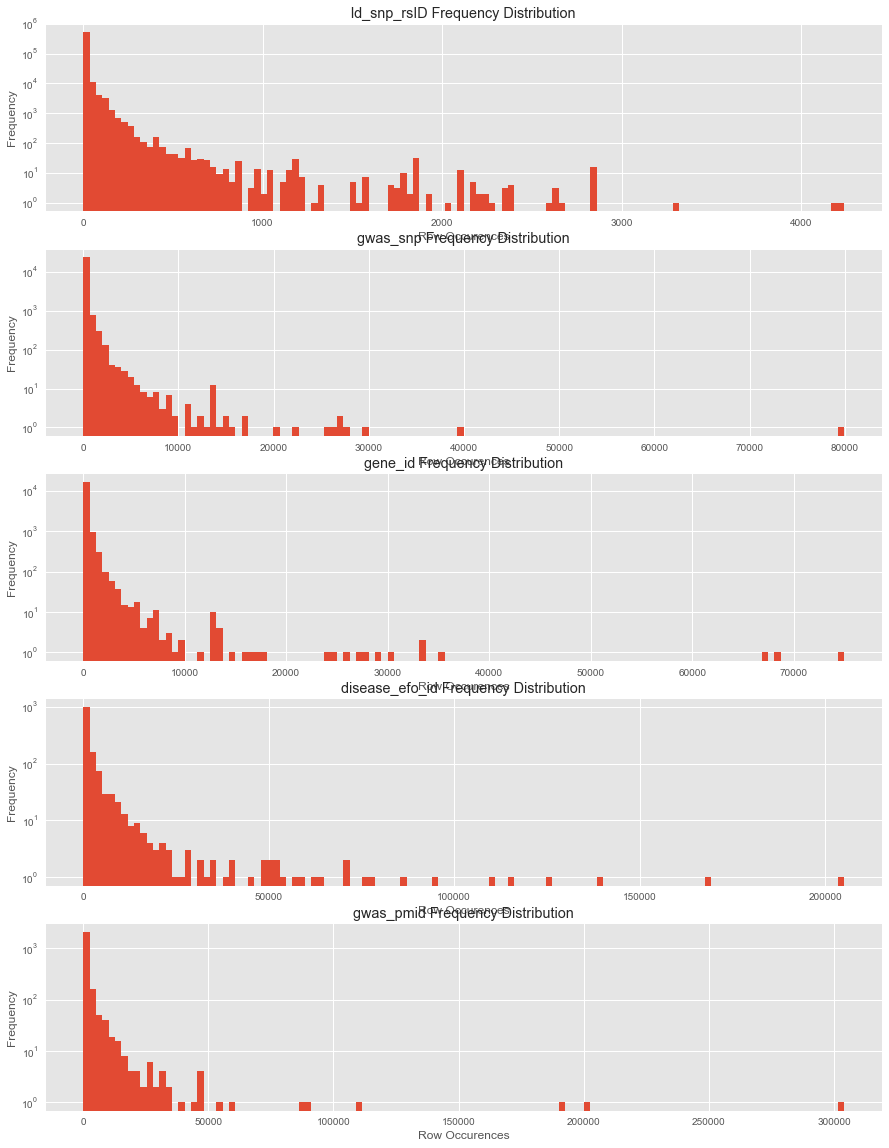

In [6]:
plt.figure(figsize=(15, 20))

for (i, c) in enumerate(primary_key):
    groups = pg.groupby(c)
    group_frequencies = groups.size()

    plt.subplot(5, 1, i + 1)
    plt.hist(group_frequencies, bins=120, log=True)
    plt.title('{} Frequency Distribution'.format(c))
    plt.xlabel('Row Occurences')
    plt.ylabel('Frequency')

plt.show()

**Question**: How many unique `(ld_snp_rsID, gwas_snp)` pairs are there? How about other pairwise combinations of the unique key (there are 5C2=10 of them)?

In [37]:
import itertools

pairs = itertools.combinations(primary_key, 2)
for (i, c) in enumerate(pairs):
    print('{} unique pairs: {}'.format(c, len(pg.groupby(c).size())))

('ld_snp_rsID', 'gwas_snp') unique pairs: 975297
('ld_snp_rsID', 'gene_id') unique pairs: 1340760
('ld_snp_rsID', 'disease_efo_id') unique pairs: 937509
('ld_snp_rsID', 'gwas_pmid') unique pairs: 997560
('gwas_snp', 'gene_id') unique pairs: 150125
('gwas_snp', 'disease_efo_id') unique pairs: 35621
('gwas_snp', 'gwas_pmid') unique pairs: 29503
('gene_id', 'disease_efo_id') unique pairs: 153564
('gene_id', 'gwas_pmid') unique pairs: 156233
('disease_efo_id', 'gwas_pmid') unique pairs: 3808


**Question**: How frequestly does each `(ld_snp_rsID, gwas_snp)` pair occur across all rows? How about other pairwise combinations of the unique key (there are 5C2=10 of them)?

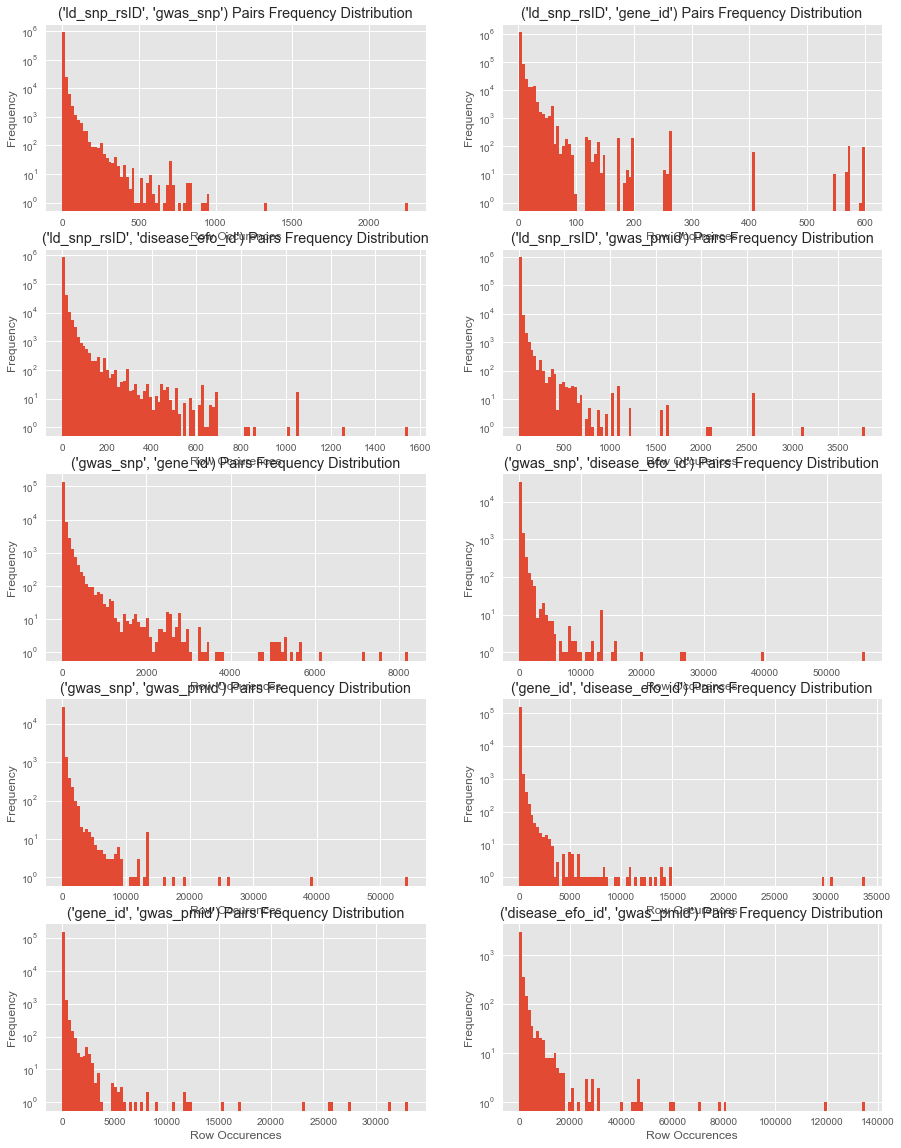

In [61]:
plt.figure(figsize=(15, 20))

pairs = itertools.combinations(primary_key, 2)
for (i, c) in enumerate(pairs):
    connections = pg.groupby(c)
    connection_frequencies = connections.size()

    plt.subplot(5, 2, i + 1)
    plt.hist(connection_frequencies, bins=120, log=True)
    plt.title('{} Pairs Frequency Distribution'.format(c))
    plt.xlabel('Row Occurences')
    plt.ylabel('Frequency')

plt.show()

### Score, r2 and GWAS p-value
Of the above pairs, three have an associated strength, as below.

| Strength measure | Pair | Range |
| -- | -- | -- |
| score | ('ld_snp_rsID', 'gene_id') | [0, 38] |
| r2 | ('ld_snp_rsID', 'gwas_snp') | [0.7, 1.0] |
| gwas_pvalue | ('gwas_snp', 'disease_efo_id') | [0, 1] |

The distribution can be given across all rows *OR* across all unique pairs (as in the table). Both are displayed below, for each strength measure.

**Question**: How is the POSTGAP score distributed?

In [9]:
def plot_strength_distribution(connection_strength_all, connection_strength_no_dupes, label):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(connection_strength_all.values.flatten(), bins=100, log=True)
    plt.title('{} Distribution'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    plt.subplot(122)
    plt.hist(connection_strength_no_dupes.values.flatten(), bins=100, log=True)
    plt.title('{} Distribution (no duplicate pairs)'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.show()

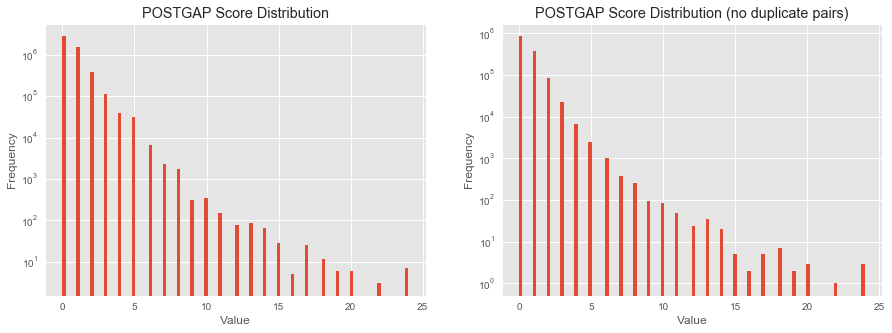

In [10]:
score_all = pg['score']
# TODO: Check score is the same across all (gene_id, ld_snp_rsID) pairs (to justify use of first())
score_no_dupes = pg.groupby(['gene_id', 'ld_snp_rsID'])['score'].first()
plot_strength_distribution(score_all, score_no_dupes, 'POSTGAP Score')

**Question**: How is the `r2` value distributed?

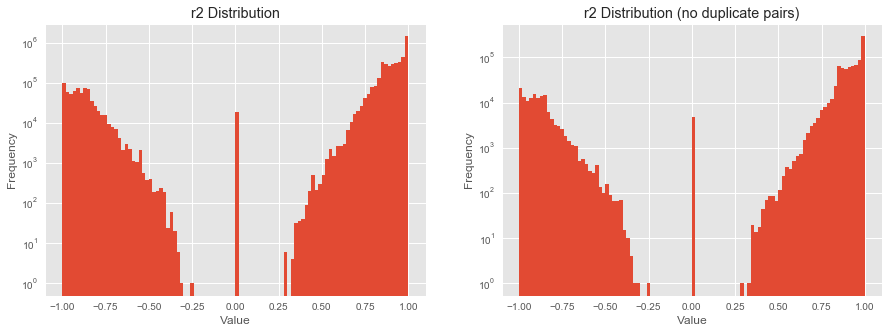

In [11]:
r2_all = pg['r2']
r2_no_dupes = pg.groupby(['ld_snp_rsID', 'gwas_snp'])['r2'].first()
plot_strength_distribution(r2_all, r2_no_dupes, 'r2')
# note: r2 col appears to contain r, not r2

**Question**: How is the `gwas_pvalue` distributed?

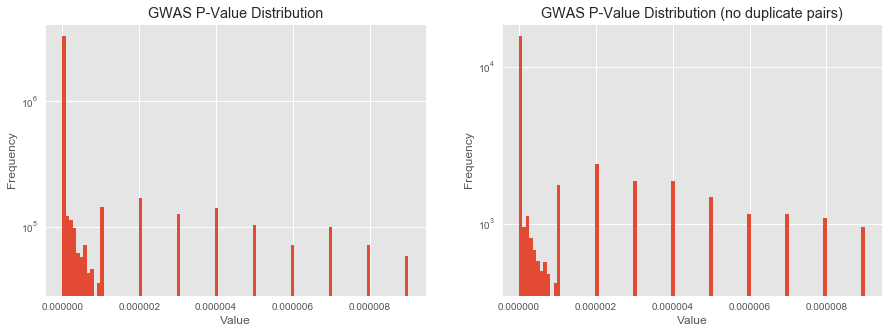

In [12]:
pval_all = pg['gwas_pvalue']
# TODO: check if the grouping should include pmid for uniqueness of first()
pval_no_dupes = pg.groupby(['gwas_snp', 'disease_efo_id'])['gwas_pvalue'].first()
plot_strength_distribution(pval_all, pval_no_dupes, 'GWAS P-Value')

## Connection degree distribution
One key aspect of the POSTGAP data model is the clusters of `ld_snp`s per `lead_snp`. We could ask the following questions:

**Question**: If a given `ld_snp` is chosen, how many unique `lead_snp`s is it linked to?

**Question**: If a given `lead_snp` is chosen, how many unique `ld_snp`s is it linked to?

In [13]:
def plot_connection_degree_distribution(a_degrees, b_degrees, a_label, b_label):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(a_degrees.values.flatten(), bins=100, log=True)
    plt.title('{}s per {} Distribution'.format(b_label, a_label))
    plt.ylabel('Frequency')
    plt.xlabel('Degree')

    plt.subplot(122)
    plt.hist(b_degrees.values.flatten(), bins=100, log=True)
    plt.title('{}s per {} Distribution'.format(a_label, b_label))
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

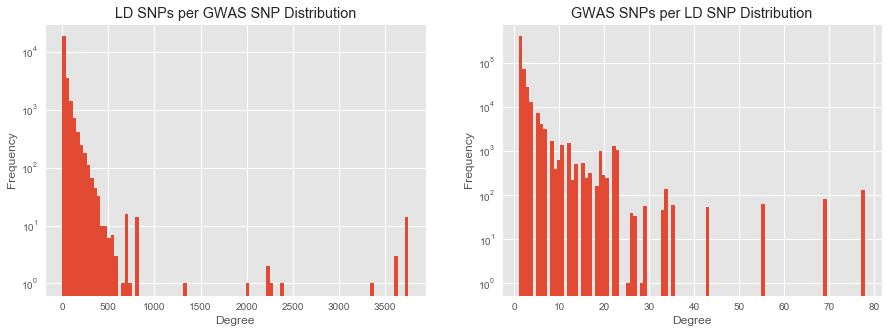

In [14]:
# Note: use count() to include row repeats, or nunique() to skip repeats
ld_snps_per_lead_snp = pg.groupby('gwas_snp')['ld_snp_rsID'].nunique()
lead_snps_per_ld_snp = pg.groupby('ld_snp_rsID')['gwas_snp'].nunique()
plot_connection_degree_distribution(ld_snps_per_lead_snp, lead_snps_per_ld_snp, 'GWAS SNP', 'LD SNP')

Similarly:
    
**Question**: If a given `gene` is chosen, how many `ld_snp`s is it linked to?
    
**Question**: If a given `ld_snp` is chosen, how many `gene`s is it linked to?

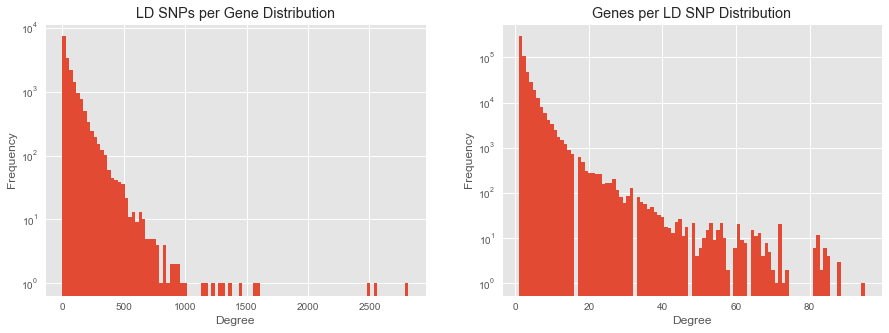

In [15]:
ld_snps_per_gene = pg.groupby('gene_id')['ld_snp_rsID'].nunique()
genes_per_ld_snp = pg.groupby('ld_snp_rsID')['gene_id'].nunique()
plot_connection_degree_distribution(ld_snps_per_gene, genes_per_ld_snp, 'Gene', 'LD SNP')

Similarly:

**Question**: If a given `lead_snp` is chosen, how many `disease`s is it linked to?

**Question**: If a given `disease` is chosen, how many `lead_snp`s is it linked to?

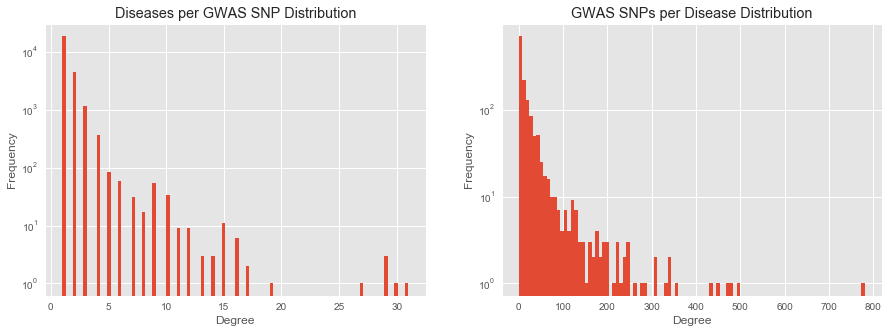

In [16]:
diseases_per_lead_snp = pg.groupby('gwas_snp')['disease_efo_id'].nunique()
lead_snps_per_disease = pg.groupby('disease_efo_id')['gwas_snp'].nunique()
plot_connection_degree_distribution(diseases_per_lead_snp, lead_snps_per_disease, 'GWAS SNP', 'Disease')

## Clusters and their windows
From the perspective of the planned visualisation, clusters of `ld_snp`s might be indexed by:
* A: `gwas_snp` (ie. lumping all genes/diseases in; perhaps not as useful, **but** original test slices of this format)
* B: `gwas_snp, gene_id` (ie. lumping all diseases in; perhaps useful on target profile page)
* C: `gwas_snp, disease_efo_id` (ie. lumping all genes in; perhaps useful on disease profile page)
* D: `gwas_snp, gene_id, disease_efo_id` (ie. as specific as possible; perhaps useful on the evidence page)

**Question**: Under each cluster indexing scheme, how many unique `ld_snp`s are there per cluster? 

**Question**: Under each cluster indexing scheme, what is the base pair window size of the `ld_snp`s? 

In [17]:
set_a = ['gwas_snp']
set_b = ['gwas_snp', 'gene_id']
set_c = ['gwas_snp', 'disease_efo_id']
set_d = ['gwas_snp', 'gene_id', 'disease_efo_id']

In [18]:
def plot_cluster_scheme_summary(key_set):
    clusters = pg[[*key_set, 'ld_snp_rsID', 'pos', 'chrom']].drop_duplicates().groupby(key_set)
    cluster_sizes = clusters['ld_snp_rsID'].nunique() # again the nunique/count distinction
    
    sorted_sizes = cluster_sizes.sort_values().values
    smallest = sorted_sizes[0]
    largest = sorted_sizes[-1]
    
    cluster_windows = clusters['pos'].agg([np.min, np.max])
    
    # TODO: currently cluster_window_sizes contains dupes (by ld_snp_rsID) that cluster_sizes removes with nunique()
    #       how to remove?
    cluster_window_sizes = cluster_windows.T.apply(lambda x: x['amax'] - x['amin'])
    sorted_window_sizes = cluster_window_sizes.sort_values().values
    narrowest = sorted_window_sizes[0]
    widest = sorted_window_sizes[-1]
    
    print('Clustering by {}'.format(key_set))
    print('Number of clusters: {}'.format(len(cluster_sizes)))
    print('Smallest {};  Largest {}'.format(smallest, largest))
    print('Narrowest {};  Widest {}'.format(narrowest, widest))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(cluster_sizes, bins=50, log=True)
    plt.title('Cluster Size Distribution\n(by {})'.format(key_set))
    plt.ylabel('Frequency')
    plt.xlabel('Size')

    plt.subplot(122)
    plt.hist(cluster_window_sizes, bins=50, log=True)
    plt.title('Cluster Window Range Distribution\n(by {})'.format(key_set))
    plt.ylabel('Frequency')
    plt.xlabel('Range (bp)')
    plt.show()

Clustering by ['gwas_snp']
Number of clusters: 25223
Smallest 1;  Largest 3755
Narrowest 0;  Widest 1402110


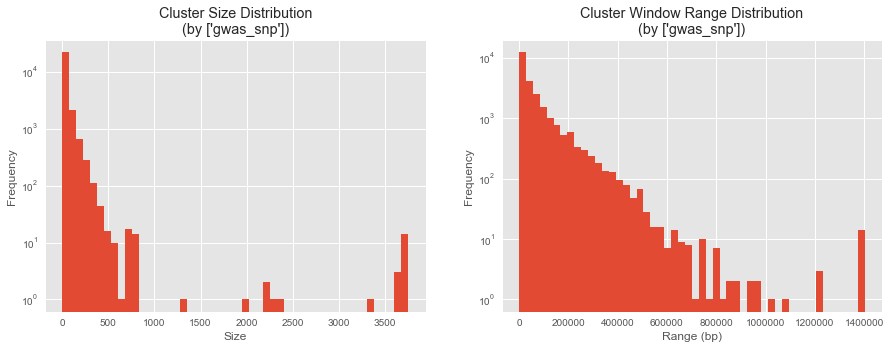

Clustering by ['gwas_snp', 'gene_id']
Number of clusters: 150125
Smallest 1;  Largest 2812
Narrowest 0;  Widest 1402110


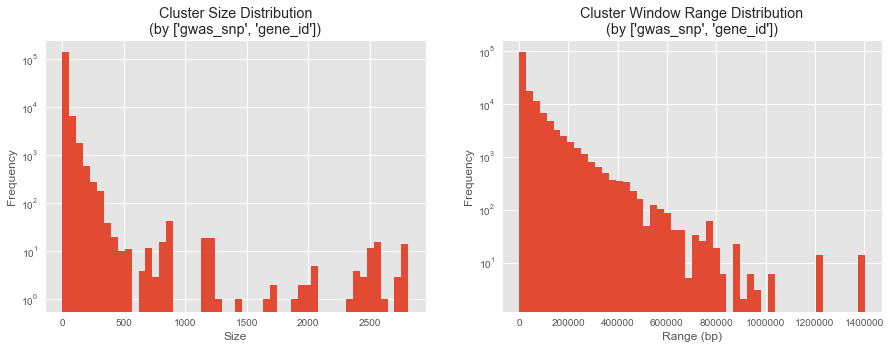

Clustering by ['gwas_snp', 'disease_efo_id']
Number of clusters: 35621
Smallest 1;  Largest 3755
Narrowest 0;  Widest 1402110


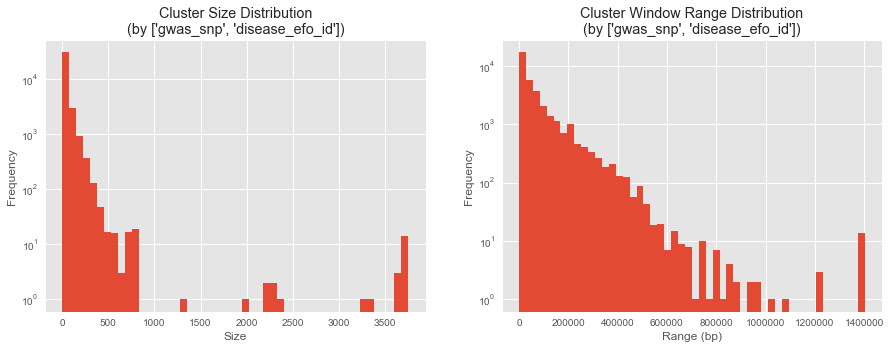

Clustering by ['gwas_snp', 'gene_id', 'disease_efo_id']
Number of clusters: 221748
Smallest 1;  Largest 2812
Narrowest 0;  Widest 1402110


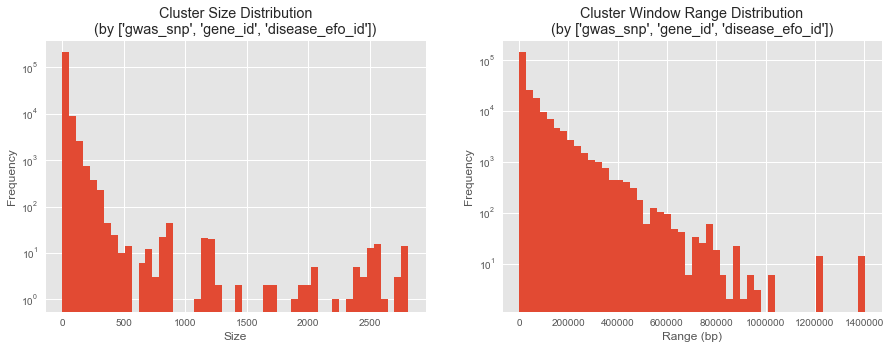

In [19]:
plot_cluster_scheme_summary(set_a)
plot_cluster_scheme_summary(set_b)
plot_cluster_scheme_summary(set_c)
plot_cluster_scheme_summary(set_d)

**Question**: Does the LD SNP chromosome always match the gene chromosome?

In [20]:
rows_different_chroms = pg[pg.chrom != pg.gene_chrom]
rows_different_chroms[['ld_snp_rsID', 'gene_symbol', 'chrom', 'gene_chrom']].groupby(['chrom', 'gene_chrom']).first()

ld_snp_rsID   gene_symbol
chrom                gene_chrom                                     
1                    6                      rs11205277           HFE
                     10                    rs554523047         DHX32
                     16                    rs112103825         SF3B3
                     17                    rs554523047      ARHGAP44
                     18                     rs11356503        MYL12A
                     1                      rs11576868    AC096644.1
                     HSCHR1_1_CTG31          rs4520447       GATAD2B
2                    3                       rs1902747        P2RY14
                     6                      rs72985419      HLA-DRB1
                     10                      rs6735946          ATE1
                     16                     rs10205592           GP2
                     17                      rs2160232         OR1G1
                     18                     rs12618567         SOGA2
                     2                       rs4530361        UGT1A8
                     HSCHR2_1_CTG12           rs580613        ABCB11
3                    4                     rs369898918       ADAMTS3
                     6                      rs11359982       C6orf89
                     3                      rs79896191          CAV3
                     4                       rs7646118       ADAMTS3
4                    8                      rs28374205        DENND3
                     13                     rs13114719         IFT88
                     21                      rs1494950        ADARB1
                     22                      rs9918077         LIMK2
                     4                      rs28749263         PRKG2
                     HSCHR4_1_CTG12         rs71620343          TDO2
5                    6                      rs17225282        SERAC1
                     8                      rs35293890       LAPTM4B
                     19                      rs4912799        CHAF1A
                     5                      rs66491003  CTD-2228K2.5
6                    1                      rs35706352     HIST2H2BF
...                                                ...           ...
7                    7                      rs35432859          AGMO
                     1                      rs75119251         ITPKB
                     12                      rs4724799         HOXC9
                     17                     rs12702509          CBX8
                     2                      rs74446409           TTL
                     HSCHR7_1_CTG6           rs4256516          WEE2
8                    8                       rs4412394         CSMD3
9                    9                       rs1995933           AUH
HSCHR10_1_CTG5       10                      rs2291429        MARCH8
HSCHR15_1_CTG4       15                    rs150848999       GOLGA8G
HSCHR16_1_CTG3_1     16                      rs7184362         CES5A
HSCHR17_4_CTG4       17                      rs9912181         KRT20
HSCHR17_5_CTG4       HSCHR17_6_CTG4        rs199651132      KRTAP9-2
HSCHR17_6_CTG4       HSCHR17_5_CTG4        rs199651132      KRTAP9-4
HSCHR18_2_CTG2       18                      rs6566288          DSEL
HSCHR19LRC_COX1_CTG1 19                      rs2361797          RPS9
                     HSCHR19LRC_PGF1_CTG1    rs2361797          RPS9
HSCHR19LRC_PGF1_CTG1 19                      rs2361797          RPS9
                     HSCHR19LRC_COX1_CTG1    rs2361797          RPS9
HSCHR19_1_CTG3       19                      rs4808260        ZNF626
HSCHR19_1_CTG3_1     19                     rs10407640      KIAA0355
HSCHR1_1_CTG31       1                       rs4434872       GATAD2B
HSCHR1_2_CTG31       1                     rs140081212          MTX1
                     1                     rs140081212          MTX1
HSCHR22_1_CTG1       22                      rs5758659         TCF20
HSCHR22_2_CTG1       22                  

**Question**: How many unique `['ld_snp_rsID', 'gene_symbol']` pairs per `['chrom', 'gene_chrom']` pair?

In [21]:
rows_different_chroms[['ld_snp_rsID', 'gene_symbol', 'chrom', 'gene_chrom']].drop_duplicates().groupby(['chrom', 'gene_chrom']).size()

chrom                 gene_chrom          
1                     6                          2
                      10                         2
                      16                         2
                      17                         9
                      18                         4
                      1                       6634
                      HSCHR1_1_CTG31             2
2                     3                         14
                      6                          3
                      10                        26
                      16                         1
                      17                        13
                      18                         1
                      2                       8783
                      HSCHR2_1_CTG12            23
3                     4                         25
                      6                         46
                      3                       4277
                      4                

**Question**: How does POSTGAP score vary with distance (of LD SNP to gene TSS)?

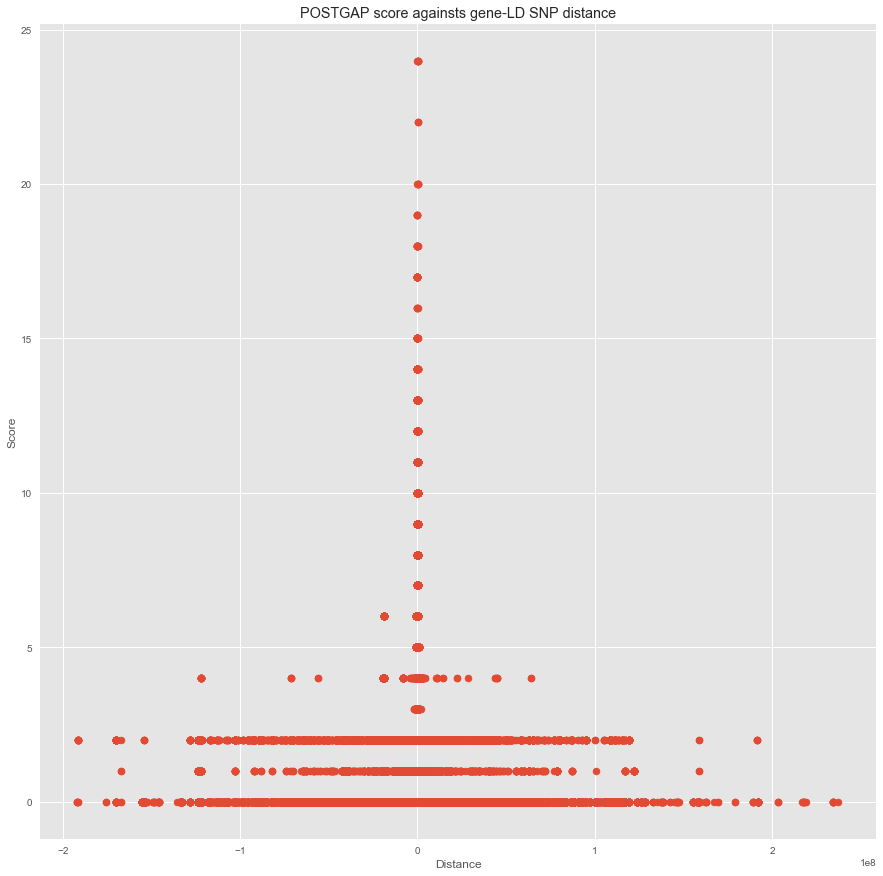

In [22]:
dists = pg.pos - pg.gene_tss
plt.figure(figsize=(15, 15))
plt.scatter(dists, pg.score)
plt.title('POSTGAP score againsts gene-LD SNP distance')
plt.ylabel('Score')
plt.xlabel('Distance')
plt.show()

**Question**: Which chromosomes are listed? Will the non-standard ones be a problem for visualisation?

In [23]:
pg.chrom.unique()

array([10, 12, 14, 9, 7, 15, 8, 11, 19, 4, 16, 2, 3, 5, 6, 13, 1, 18, 22,
       20, 17, '1', '10', '15', '5', '3', '6', '8', '2', '7', '11',
       'HSCHR1_2_CTG31', '4', '9', '17', '19', '22', '16', '20', '18',
       '13', '12', 'X', '21', '14', 21, 'HSCHR2_1_CTG12', 'HSCHR2_2_CTG12',
       'HSCHR22_1_CTG1', 'HSCHR1_1_CTG31', 'HSCHR19LRC_COX1_CTG1',
       'HSCHR19LRC_PGF1_CTG1', 'HSCHR19_1_CTG3_1', 'HSCHR16_1_CTG3_1',
       'HSCHR19_1_CTG3', 'HSCHR22_2_CTG1', 'HSCHR10_1_CTG5',
       'HSCHR4_1_CTG12', 'HSCHR5_1_CTG2', 'HSCHR15_1_CTG4',
       'HSCHR17_4_CTG4', 'HSCHR17_6_CTG4', 'HSCHR17_5_CTG4',
       'HSCHR18_2_CTG2'], dtype=object)

**Question**: What are the distributions of the POSTGAP score constituent parts like?

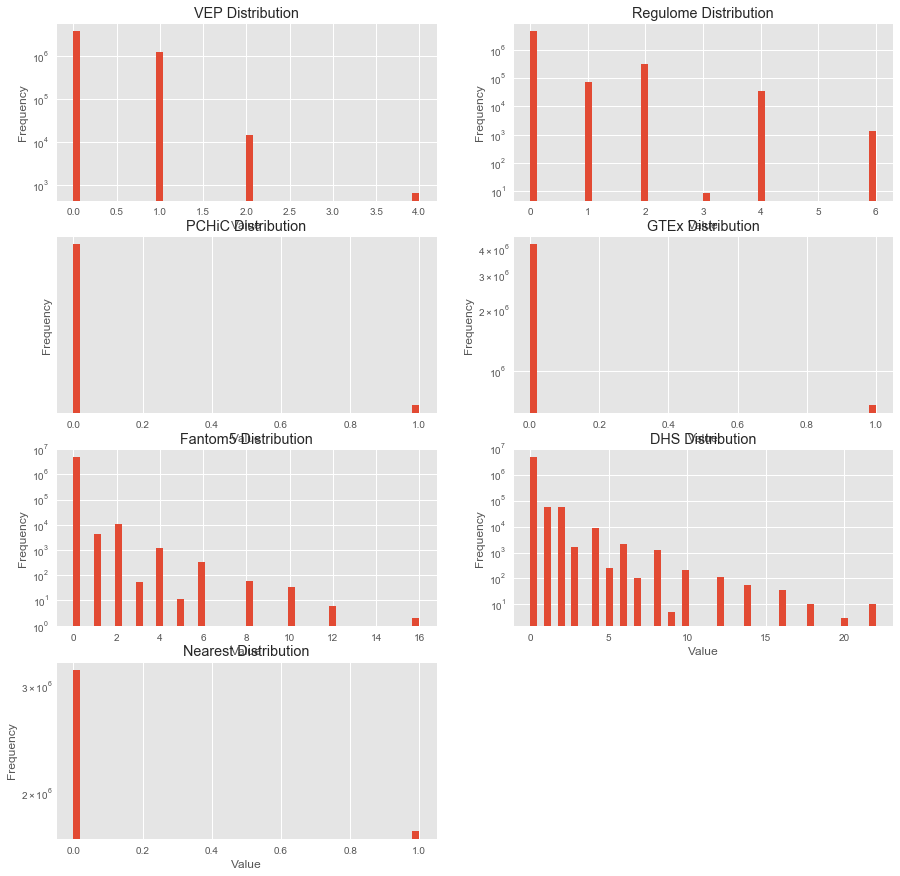

In [24]:
parts = ['VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest']

# Note: this currently counts across rows for frequency, may also be interested in counts across unique (gene, LD SNP) pairs
plt.figure(figsize=(15, 15))
for (i, p) in enumerate(parts):
    plt.subplot(4, 2, i + 1)
    plt.hist(pg[p], bins=50, log=True)
    plt.title('{} Distribution'.format(p))
    plt.ylabel('Frequency')
    plt.xlabel('Value')

plt.show()

**Question**: For a given (gene, LD SNP) pair, are the score constituents always the same? (I would expect this on the assumption that POSTGAP score is gene-snp centric.)

In [62]:
combs = itertools.combinations(parts, 2)
pair = ['gene_id', 'ld_snp_rsID']
unique_counts_per_gene_snp = pg[[*pair, *parts]].groupby(pair).nunique()
unique_count_is_1_across_all_cols = unique_counts_per_gene_snp.apply(lambda x: x == 1).all(axis=1)
# Note: If the answer is yes to the above, would expect unique_count_is_1_across_all_cols to be always true.
# The following (gene, snp) pairs must have at least one constituent part that is multi-valued.
unique_count_is_1_across_all_cols[unique_count_is_1_across_all_cols == False]

gene_id          ld_snp_rsID
ENSG00000047849  rs4858871      False
ENSG00000065413  rs34792919     False
ENSG00000083067  rs34968581     False
ENSG00000088053  rs1671152      False
ENSG00000100197  rs1058172      False
                 rs1065852      False
                 rs2142694      False
                 rs36093924     False
                 rs5758659      False
ENSG00000104626  rs140242735    False
ENSG00000107862  rs72433571     False
ENSG00000110514  rs34047925     False
ENSG00000112137  rs550542017    False
ENSG00000115604  rs138087973    False
ENSG00000120071  rs201443147    False
                 rs368919625    False
ENSG00000122870  rs147608004    False
ENSG00000125505  rs2576452      False
ENSG00000136243  rs1637215      False
ENSG00000143379  rs67781123     False
ENSG00000143554  rs10908474     False
ENSG00000143614  rs4434872      False
                 rs67881926     False
                 rs7554469      False
ENSG00000152254  rs2232315      False
                 rs56

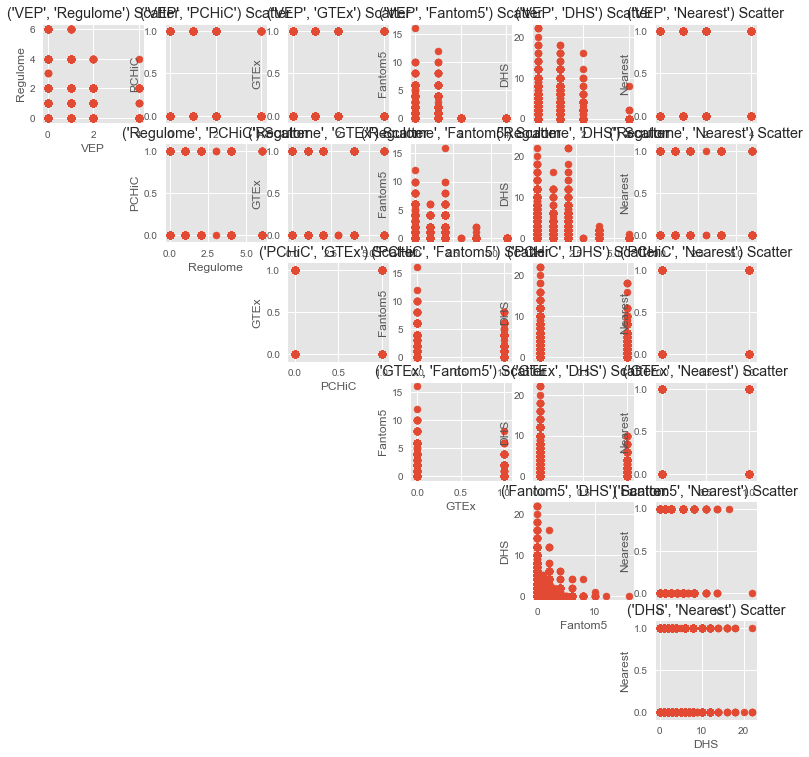

In [64]:
values_per_gene_snp = pg[[*pair, *parts]].groupby(pair).first()
combs = itertools.combinations(parts, 2)

plt.figure(figsize=(15, 15))
for (i, c) in enumerate(combs):
    plt.subplot(7, 7, (parts.index(c[0]) * 7) + parts.index(c[1]) + 1)
    plt.scatter(values_per_gene_snp[c[0]], values_per_gene_snp[c[1]])
    plt.title('{} Scatter'.format(c))
    plt.ylabel('{}'.format(c[1]))
    plt.xlabel('{}'.format(c[0]))

plt.show()

In [ ]:
# TODO: Investigate
#       * Distribution across chromosomes
#       * Distribution across 1Mbp windows (since this is some sort of cut-off in POSTGAP)
#       * Can we show a gene against ld snp co-occurrence matrix? What about gene against disease?
# .     * More thoughts...?